# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

The ToTensor transformation is essential for converting images into a format that PyTorch can work with(tensors).

The Normalize transformation is critical for standardizing the input data, which can lead to faster convergence during training. The mean and standard deviation values used should be calculated based on the dataset we are working with.


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 87340077.95it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24561170.69it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31539807.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10942291.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders

The dataloader_args dictionary is used to configure the DataLoader. Using a larger batch size when CUDA is available can help utilize the GPU more efficiently.

The shuffle=True argument in dataloader_args ensures that the data is shuffled at the beginning of each epoch, which can help improve model generalization.

num_workers is set to 4 to enable parallel data loading, which can speed up the data loading process.

pin_memory=True allows for faster data transfer to the GPU by pinning memory on the host (CPU) side.

The DataLoader is responsible for loading the data in batches and applying any specified transformations. It provides an iterable over the dataset for easy integration with training and testing loops.

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


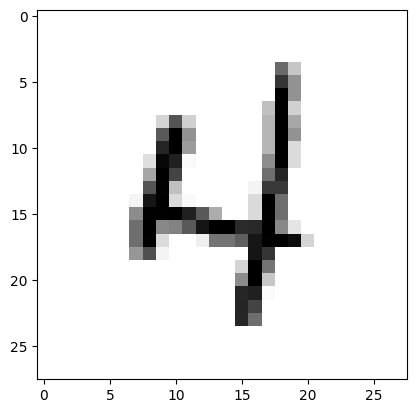

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)


print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

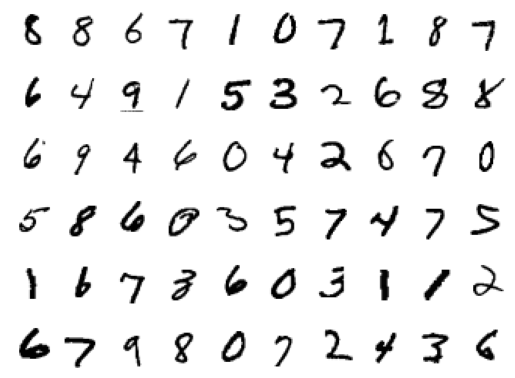

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [16]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [17]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [18]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [19]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.06836789101362228 Batch_id=468 Accuracy=88.49: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]



Test set: Average loss: 0.0646, Accuracy: 9826/10000 (98.26%)

EPOCH: 1


Loss=0.058873992413282394 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]



Test set: Average loss: 0.0482, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.08923535794019699 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]



Test set: Average loss: 0.0376, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.03535505384206772 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]



Test set: Average loss: 0.0286, Accuracy: 9916/10000 (99.16%)

EPOCH: 4


Loss=0.027469271793961525 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]



Test set: Average loss: 0.0296, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.06256068497896194 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 27.89it/s]



Test set: Average loss: 0.0296, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.006558589171618223 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 28.20it/s]



Test set: Average loss: 0.0318, Accuracy: 9900/10000 (99.00%)

EPOCH: 7


Loss=0.012444457970559597 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 27.34it/s]



Test set: Average loss: 0.0226, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.02527318149805069 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]



Test set: Average loss: 0.0257, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.011563378386199474 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]



Test set: Average loss: 0.0246, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.10149139910936356 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:16<00:00, 27.96it/s]



Test set: Average loss: 0.0262, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.04498409852385521 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]



Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.00965037103742361 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]



Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.02545694261789322 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]



Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.01177205890417099 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]



Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 15


Loss=0.0063474723137915134 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]



Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.006313936319202185 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.31it/s]



Test set: Average loss: 0.0174, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.00968605000525713 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]



Test set: Average loss: 0.0162, Accuracy: 9948/10000 (99.48%)

EPOCH: 18


Loss=0.029632190242409706 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:15<00:00, 29.36it/s]



Test set: Average loss: 0.0163, Accuracy: 9954/10000 (99.54%)

EPOCH: 19


Loss=0.046013880521059036 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 26.79it/s]



Test set: Average loss: 0.0163, Accuracy: 9946/10000 (99.46%)



Text(0.5, 1.0, 'Test Accuracy')

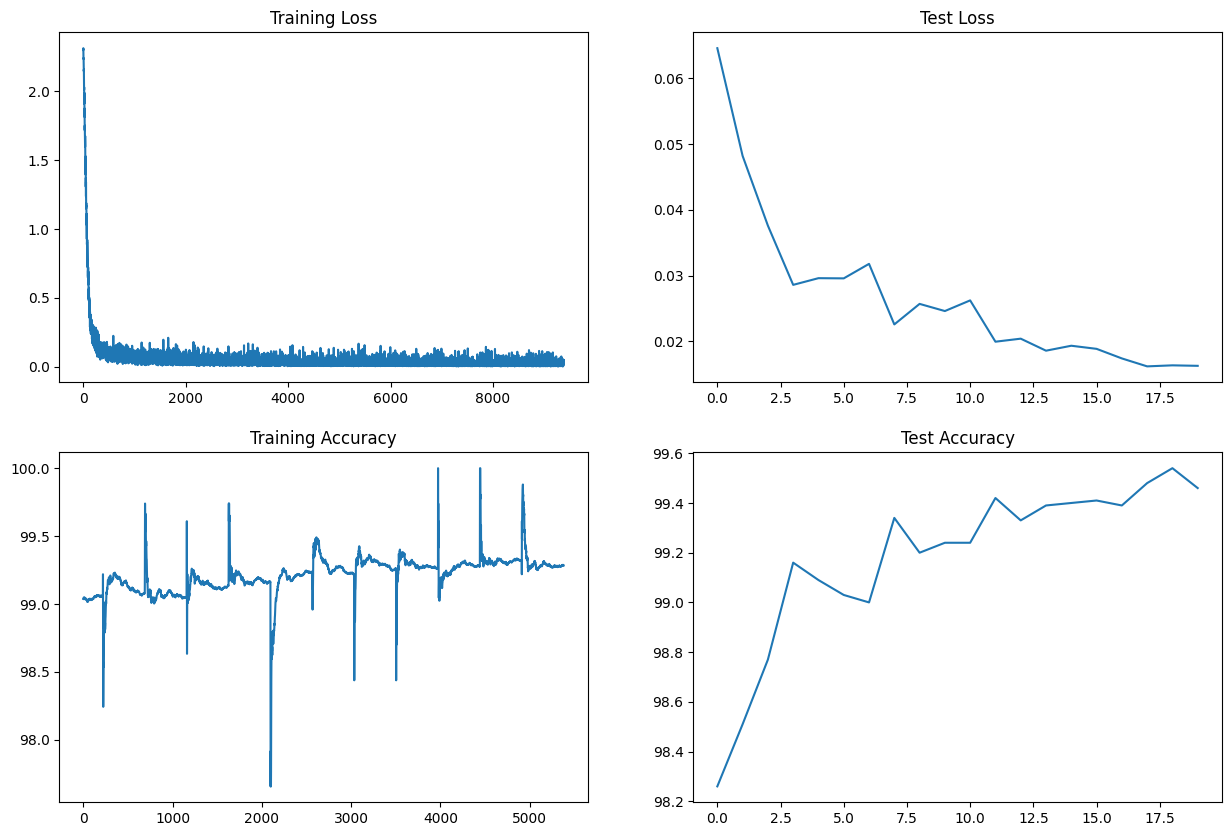

In [20]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")